# SDOF system with energy dissipation based upon snap-back mechanisms

In [1]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import integrator as inte

In [2]:
sismo = np.loadtxt('medellin.txt')
ndats = len(sismo)
t_max = (ndats-10)*0.02
sismo = sismo*9.8
t     = np.linspace(0 , t_max , ndats)

## (1)-Simple sdof oscillator

Consider the following reference oscillator:

<center><img src="img/reference.png" alt="Picture1.png" style="width:400px"></center>

with natural frequency:

$$\omega^2=\frac{K_B}{M_B}$$

and with governing ODE

$$M_B\ddot U(t)+C_B\dot U(t)+K_BU(t)=-M_B \ddot U_G$$

#######################################################

Stiffness for the reference system         = 3.2227279677026472
Natural frequency for the reference system = 1.7951958020513104
Damping factor for the reference    system = 0.07180783208205242

#######################################################


<IPython.core.display.Javascript object>


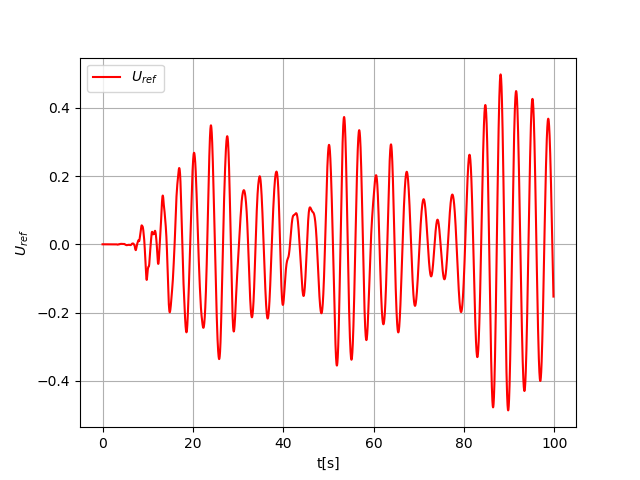

Maximum displacement in the refernce system U_max_ref = 0.4980704299505716


In [3]:
# System parameters
#
M_B   = 1.0                            #Building mass
T     = 3.5                            #Natural period
K_B   = ((2*np.pi/T)**2)*M_B           #Building stiffness
omega = np.sqrt(K_B/M_B)
C_B   = 2*0.02*omega*M_B               #Building dashpot coefficient
print('#######################################################')
print()
print ('Stiffness for the reference system         =' , K_B)
print ('Natural frequency for the reference system =' , omega)
print ('Damping factor for the reference    system =' , C_B)
print()
print('#######################################################')
#
y0 = [0.0 , 0.0]                       # Initial conditions
t  = np.linspace(0 , t_max , ndats)    #Time span
#
#------Integrate---------
#
sol  = odeint(inte.model , y0 , t , args=(M_B , C_B , K_B , sismo))
#
#------Plot---------
#
plt.figure(0)
U_ref = sol[:, 0]
U_max_ref =np.amax(U_ref)
print('Maximum displacement in the refernce system U_max_ref =' , U_max_ref)
plt.plot(t, U_ref , 'r', label='$U_{ref}$')
plt.legend(loc='best')
plt.ylabel('$U_{ref}$')
plt.xlabel('t[s]')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


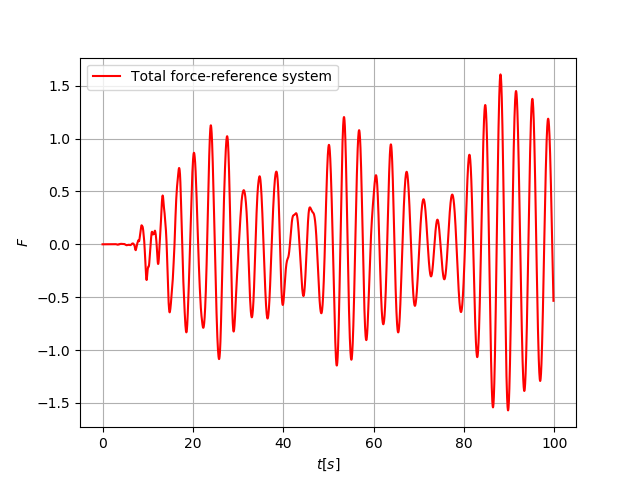

Maximum shear in the refernce system F_max_ref = 1.6064963964295025


In [4]:
plt.figure(1)
V_ref = sol[: , 1]
F_r = K_B*U_ref + C_B*V_ref
F_max_ref =np.amax(F_r)
print('Maximum shear in the refernce system F_max_ref =' , F_max_ref)
plt.plot(t , F_r , 'r', label='Total force-reference system')
plt.legend(loc='best')
plt.xlabel('$t[s]$')
plt.ylabel('$F$')
plt.grid()
plt.show()

##  (2) The Misses truss

<center><img src="img/truss.png" alt="Picture1.png" style="width:200px"></center>

Consider the following device parameters:

- $K_s$   :    Spring stiffness
- $K_{VM}$: Stiffness of the linear region in the constitutive law for the Misses truss.
- $K_D$   : Effective stiffness of the truss-spring device given by:

$$K_D=\left(\frac1{k_s}+\frac1{K_{VM}}\right)^{-1}$$

where:

$$K_{VM}=\frac{2\mathrm\pi}\lambda F_0$$

is the stiffness in the Misses truss.

In [5]:
#
# Misses truss parameters
#
lmda  = U_max_ref/2            #Wavelength for the Misses truss F-d relationship
F_0   = 0.10*F_max_ref         #Force amplitude for the Misses truss
K_VM  = (2.0*np.pi/lmda)*F_0
#
print('#######################################################')
print()
print('Wavelength in the Misses truss =' , lmda)
print('Stiffness in the Misses truss  =' , K_VM)
print()
print('#######################################################')
#
fac = 1.0
FM , uu = inte.plot_misses(F_0 , lmda , ndats , fac)

#######################################################

Wavelength in the Misses truss = 0.2490352149752858
Stiffness in the Misses truss  = 4.053207718066909

#######################################################


<IPython.core.display.Javascript object>


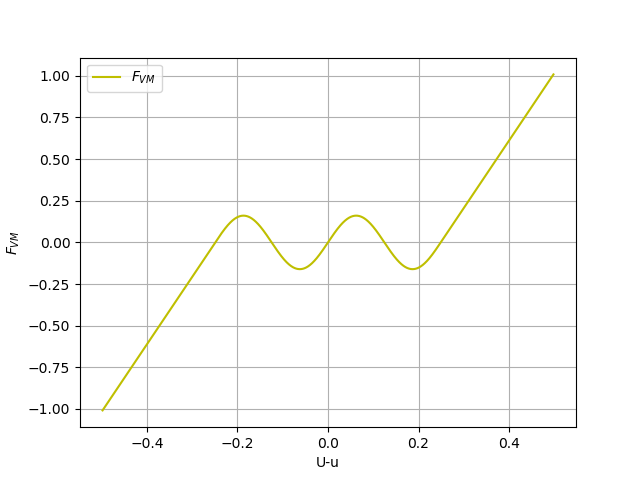

In [6]:
plt.figure(2)
plt.plot(uu , FM , 'y', label='$F_{VM}$')
plt.legend(loc='best')
plt.xlabel('U-u')
plt.ylabel('$F_{VM}$')
plt.grid()
plt.show()

## (3) System with added device

<center><img src="img/composite.png" alt="Picture1.png" style="width:500px"></center>

The dissipation device corresponds to a Misses truss with a spring of stiffness $k_s$

For the oscillator we have:

$$M_B\ddot{U}_B+ \widehat C_B\dot U_B\;+ \widehat K_BU_B+F_{VM}(U_B-u)=-M_B \ddot U_G$$

and for the device:

$$m\ddot u\;+\widehat c _s\dot u\;+k_su-F_{VM}(U_B-u)=0$$

### Effective stiffness of the device $K_D$

Defining the spring stiffness as a factor of the elastic stiffness in the truss we have

$$K_s=fK_{VM}$$

we have for the device

$$K_D=\left(\frac1{k_s}+\frac1{K_{VM}}\right)^{-1}$$

where the term $K_{VM}$ was defined previously.

### Properties for equivalent systems

In order to have equivalence (in the natural frequency) between the reference system and the system with added device and assuming a constant mass we must have:

$${\widehat K}_B = K_B-K_D$$

for the linear region.

In [7]:
pf  = 0.50    
k_s = pf*K_VM                #Spring in the Misses truss
K_D =(k_s*K_VM)/(K_VM+k_s)   #Device stiffness
K_hat = K_B - K_D            #Modified building stiffness
C_hat = C_B/2
m   = 1.0e-3                 #Device fictitious mass
c_s   = C_B/2                #Device inherent damping
print('#######################################################')
print()
print('Stiffness of the modified system K_hat =' , K_hat )
print('Stiffness of the added device K_D      =' , K_D )
print('Spring stiffness k_s                   =' , k_s)
print('Stiffness of the reference system K_B  =' , K_hat + K_D)
print()
print('#######################################################')

#######################################################

Stiffness of the modified system K_hat = 1.8716587283470112
Stiffness of the added device K_D      = 1.351069239355636
Spring stiffness k_s                   = 2.0266038590334543
Stiffness of the reference system K_B  = 3.2227279677026472

#######################################################


In [8]:
y0 = [0.0 , 0.0 , 0.0 , 0.0]
#
#------Integrate---------
#
sol  = odeint(inte.dissip_device , y0 , t ,  args =(M_B , C_hat , K_hat , sismo , m , c_s , k_s , F_0 , fac , lmda))

<IPython.core.display.Javascript object>


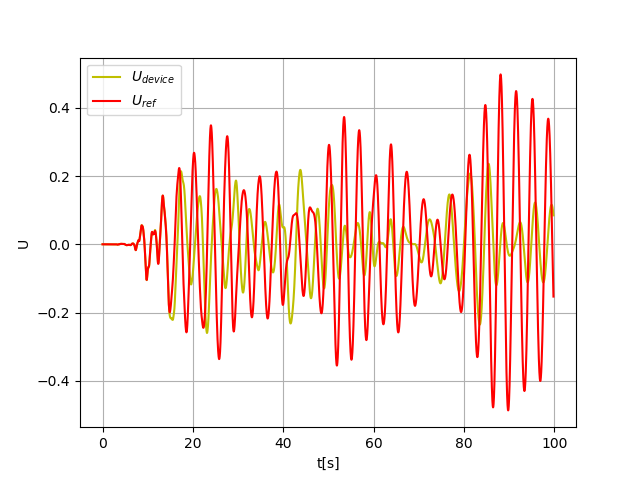

Maximum displacement in the system with the added device U_max_dev = 0.2359221905545173


In [9]:
plt.figure(3)
U_dev = sol[:, 0]
U_max_dev =np.amax(U_dev)
print('Maximum displacement in the system with the added device U_max_dev =' , U_max_dev)
plt.plot(t, U_dev , 'y', label='$U_{device}$')
plt.plot(t, U_ref , 'r', label='$U_{ref}$')
plt.legend(loc='best')
plt.xlabel('t[s]')
plt.ylabel('U')
plt.grid()
plt.show()

### Time history of forces in the reference system and system with added device

<IPython.core.display.Javascript object>


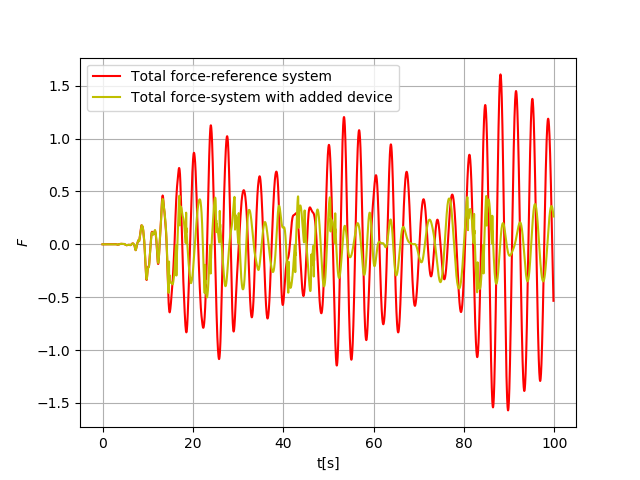

Maximum shear in the system with the added device F_max_w = 0.4597983605817527


In [10]:
plt.figure(4)
V_dev = sol[: , 1]
u_dev = sol[: , 2]
v_dev = sol[: , 3]
F_w = K_hat*U_dev + C_hat*V_dev + k_s*u_dev + c_s*v_dev
F_max_w =np.amax(F_w)
print('Maximum shear in the system with the added device F_max_w =' , F_max_w)
plt.plot(t , F_r , 'r', label='Total force-reference system')
plt.plot(t , F_w , 'y', label='Total force-system with added device')
plt.legend(loc='best')
plt.xlabel('t[s]')
plt.ylabel('$F$')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


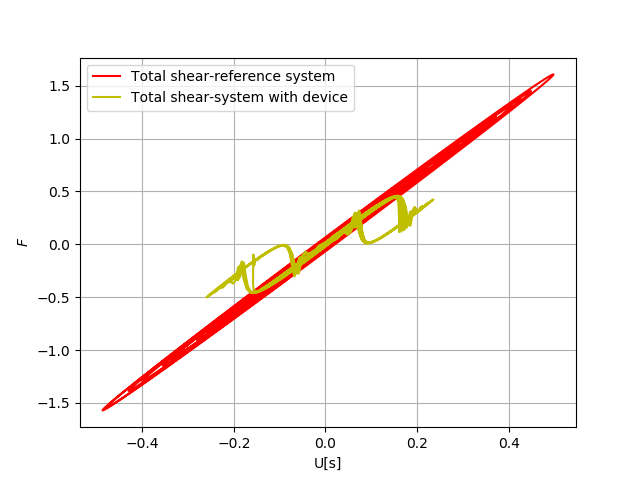

In [11]:
plt.figure(5)
plt.plot(U_ref , F_r , 'r', label='Total shear-reference system')
plt.plot(U_dev , F_w , 'y', label='Total shear-system with device')
plt.legend(loc='best')
plt.xlabel('U[s]')
plt.ylabel('$F$')
plt.grid()
plt.show()

In [12]:
print('#########################################################################')
print()
print ('Displacement ratio ====== U_max_dev /U_max_ref  =' , U_max_dev/U_max_ref)
print ('Force ratio============== F_max_dev /F_max_ref  =' , F_max_w/F_max_ref )
print()
print('#########################################################################')

#########################################################################

Displacement ratio ====== U_max_dev /U_max_ref  = 0.47367234906503114
Force ratio============== F_max_dev /F_max_ref  = 0.2862118841994738

#########################################################################


In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()